### DSC680 Sri R Sankaranarayanan
## Applied Data Science - Project 2 (week 5 - 7)
### Web Scraping - Airline Price Analysis

July 2022

In [8]:
!pip install selenium

### Using Python Selenium and latest chrome driver for Web Scraping

In [2]:
from time import sleep, strftime
from random import randint
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import smtplib
from email.mime.multipart import MIMEMultipart

# Change this to your own chromedriver path!
chromedriver_path = 'C:/ProgramData/Google Chrome/chromedriver.exe'

driver = webdriver.Chrome(executable_path=chromedriver_path) # This will open the Chrome window

driver.maximize_window() # For maximizing window
driver.implicitly_wait(20) # gives an implicit wait for 20 seconds

sleep(2)

<ipython-input-2-c727342d0168>:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=chromedriver_path) # This will open the Chrome window


### First search in Kayak.com for Flight tickets from Dallas, USA to Chennai, India (my Native)

In [5]:
Kayak='https://www.kayak.com/flights/DFW-MAA/2022-08-23/2022-08-30?sort=bestflight_a'
driver.get(Kayak)
sleep(3)

In [6]:
# This is what I used to define the "Cheapest" button

cheap_results = '//a[@data-code = "price"]'

In [7]:
driver.find_element("xpath", '//a[@data-code = "price"]')



<selenium.webdriver.remote.webelement.WebElement (session="d35ad25ddd5025c590d4ff72262a9f8c", element="706be657-d056-41e7-917a-9efb73091c73")>

In [8]:
# Loading more results to maximize the scraping

def load_more():
    try:
        more_results = '//a[@class = "moreButton"]'
        driver.find_element("xpath", more_results).click()
        # Printing these notes during the program helps me quickly check what it is doing
        print('sleeping.....')
        sleep(randint(45,60))
    except:
        pass

In [9]:
def page_scrape():
    """This function takes care of the scraping part"""
    
    xp_sections = '//*[@class="section duration"]'
    sections = driver.find_elements("xpath", xp_sections)
    sections_list = [value.text for value in sections]
    section_a_list = sections_list[::2] # This is to separate the two flights
    section_b_list = sections_list[1::2] # This is to separate the two flights
    
   
    if section_a_list == []:
        raise SystemExit
    
    # I'll use the letter A for the outbound flight and B for the inbound
    a_duration = []
    a_section_names = []
    for n in section_a_list:
        # Separate the time from the cities
        a_section_names.append(''.join(n.split()[2:5]))
        a_duration.append(''.join(n.split()[0:2]))
    b_duration = []
    b_section_names = []
    for n in section_b_list:
        # Separate the time from the cities
        b_section_names.append(''.join(n.split()[2:5]))
        b_duration.append(''.join(n.split()[0:2]))

    xp_dates = '//div[@class="section date"]'
    dates = driver.find_elements("xpath", xp_dates)
    dates_list = [value.text for value in dates]
    a_date_list = dates_list[::2]
    b_date_list = dates_list[1::2]
    # Separating the weekday from the day
    a_day = [value.split()[0] for value in a_date_list]
    a_weekday = [value.split()[1] for value in a_date_list]
    b_day = [value.split()[0] for value in b_date_list]
    b_weekday = [value.split()[1] for value in b_date_list]
    
    # getting the prices
    xp_prices = '//a[@class="booking-link"]/span[@class="price option-text"]'
    prices = driver.find_elements("xpath", xp_prices)
    prices_list = [price.text.replace('$','') for price in prices if price.text != '']
    prices_list = list(map(int, prices_list))

    # the stops are a big list with one leg on the even index and second leg on odd index
    xp_stops = '//div[@class="section stops"]/div[1]'
    stops = driver.find_elements("xpath", xp_stops)
    stops_list = [stop.text[0].replace('n','0') for stop in stops]
    a_stop_list = stops_list[::2]
    b_stop_list = stops_list[1::2]

    xp_stops_cities = '//div[@class="section stops"]/div[2]'
    stops_cities = driver.find_elements("xpath", xp_stops_cities)
    stops_cities_list = [stop.text for stop in stops_cities]
    a_stop_name_list = stops_cities_list[::2]
    b_stop_name_list = stops_cities_list[1::2]
    
    # this part gets me the airline company and the departure and arrival times, for both legs
    xp_schedule = '//div[@class="section times"]'
    schedules = driver.find_elements("xpath", xp_schedule)
    hours_list = []
    carrier_list = []
    for schedule in schedules:
        hours_list.append(schedule.text.split('\n')[0])
        carrier_list.append(schedule.text.split('\n')[1])
    # split the hours and carriers, between a and b legs
    a_hours = hours_list[::2]
    a_carrier = carrier_list[::2]
    b_hours = hours_list[1::2]
    b_carrier = carrier_list[1::2]

    
    cols = (['Out Day', 'Out Time', 'Out Weekday', 'Out Airline', 'Out Cities', 'Out Duration', 'Out Stops', 'Out Stop Cities',
            'Return Day', 'Return Time', 'Return Weekday', 'Return Airline', 'Return Cities', 'Return Duration', 'Return Stops', 'Return Stop Cities',
            'Price'])

    flights_df = pd.DataFrame({'Out Day': a_day,
                               'Out Weekday': a_weekday,
                               'Out Duration': a_duration,
                               'Out Cities': a_section_names,
                               'Return Day': b_day,
                               'Return Weekday': b_weekday,
                               'Return Duration': b_duration,
                               'Return Cities': b_section_names,
                               'Out Stops': a_stop_list,
                               'Out Stop Cities': a_stop_name_list,
                               'Return Stops': b_stop_list,
                               'Return Stop Cities': b_stop_name_list,
                               'Out Time': a_hours,
                               'Out Airline': a_carrier,
                               'Return Time': b_hours,
                               'Return Airline': b_carrier,                           
                               'Price': prices_list})[cols]
    
    flights_df['timestamp'] = strftime("%Y%m%d-%H%M") # so we can know when it was scraped
    return flights_df

In [17]:
def start_kayak(city_from, city_to, date_start, date_end):
    """City codes - it's the IATA codes!
    Date format -  YYYY-MM-DD"""
    
    kayak = ('https://www.kayak.com/flights/' + city_from + '-' + city_to +
             '/' + date_start + '-flexible/' + date_end + '-flexible?sort=bestflight_a')
    driver.get(kayak)
    sleep(randint(8,10))
    
    # sometimes a popup shows up, so we can use a try statement to check it and close
    try:
        xp_popup_close = '//button[contains(@id,"dialog-close") and contains(@class,"Button-No-Standard-Style close ")]'
        driver.find_elements("xpath", xp_popup_close)[5].click()
         
        app.run_server(debug=True, use_reloader=False)

    except Exception as e:
        pass
    sleep(randint(60,95))
    print('loading more.....')
    
#     load_more()
    
    print('starting first scrape.....')
    df_flights_best = page_scrape()
    df_flights_best['sort'] = 'best'
    sleep(randint(60,80))
    
    # Let's also get the lowest prices from the matrix on top
    matrix = driver.find_elements("xpath", '//*[contains(@id,"FlexMatrixCell")]')
    matrix_prices = [price.text.replace('$','') for price in matrix]
    matrix_prices = list(map(int, matrix_prices))
    matrix_min = min(matrix_prices)
    matrix_avg = sum(matrix_prices)/len(matrix_prices)
    
    print('switching to cheapest results.....')
    cheap_results = '//a[@data-code = "price"]'
    driver.find_element("xpath", cheap_results).click()
    sleep(randint(60,90))
    print('loading more.....')
    
#     load_more()
    
    print('starting second scrape.....')
    df_flights_cheap = page_scrape()
    df_flights_cheap['sort'] = 'cheap'
    sleep(randint(60,80))
    
    print('switching to quickest results.....')
    quick_results = '//a[@data-code = "duration"]'
    driver.find_element("xpath", quick_results).click()  
    sleep(randint(60,90))
    print('loading more.....')
    
#     load_more()
    
    print('starting third scrape.....')
    df_flights_fast = page_scrape()
    df_flights_fast['sort'] = 'fast'
    sleep(randint(60,80))
    
    # saving a new dataframe as an excel file. the name is custom made to your cities and dates
    final_df = df_flights_cheap.append(df_flights_best).append(df_flights_fast)
    final_df.to_excel('search_backups//{}_flights_{}-{}_from_{}_to_{}.xlsx'.format(strftime("%Y%m%d-%H%M"),
                                                                                   city_from, city_to, 
                                                                                   date_start, date_end), index=False)
    print('saved df.....')
    
    # We can keep track of what they predict and how it actually turns out!
    xp_loading = '//div[contains(@id,"advice")]'
    loading = driver.find_element("xpath", xp_loading).text
    xp_prediction = '//span[@class="info-text"]'
    prediction = driver.find_element("xpath", xp_prediction).text
    print(loading+'\n'+prediction)
    
    # sometimes we get this string in the loading variable, which will conflict with the email we send later
    # just change it to "Not Sure" if it happens
    weird = '¯\\_(ツ)_/¯'
    if loading == weird:
        loading = 'Not sure'
    
    username = 'rengsankar1986@gmail.com'
    password = 'xxxxxxx' #   masking for confidentiality

    server = smtplib.SMTP('smtp.outlook.com', 587)
    server.ehlo()
    server.starttls()
    server.login(username, password)
    msg = ('Subject: Flight Scraper\n\n\
Cheapest Flight: {}\nAverage Price: {}\n\nRecommendation: {}\n\nEnd of message'.format(matrix_min, matrix_avg, (loading+'\n'+prediction)))
    message = MIMEMultipart()
    message['From'] = 'rengsankar1986@gmail.com'
    message['to'] = 'rengsankar1986@gmail.com'
    server.sendmail('rengsankar1986@gmail.com', 'rengsankar1986@gmail.com', msg)
    print('sent email.....')

### Now let's get ready to get the results for Vacation right after the last day of the course :) 

In [18]:

city_from = input('From which city? ')
city_to = input('Where to? ')
date_start = input('departure date? (YYYY-MM-DD format only)')
date_end = input('Return when? (YYYY-MM-DD format only) ')

for n in range(0,5):
    start_kayak(city_from, city_to, date_start, date_end)
    print('iteration {} was complete @ {}'.format(n, strftime("%Y%m%d-%H%M")))

    
    # Wait 4 hours
    sleep(60*60*4)
    print('sleep finished.....')

From which city? DFW
Where to? MAA
departure date? (YYYY-MM-DD format only)2022-08-13
Return when? (YYYY-MM-DD format only) 2022-0828
loading more.....
starting first scrape.....


SystemExit: 

I am planning to run the above in iteration using time series analysis, append the data to an excel and then perform EDA as below, then Visualize them for understanding the factors contributing to the Airline price. This will give me good idea on when to book the flight and what is reasonable price between certain given destinations. 

### Importing Libraries for EDA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
## Testing Web Scraped dataset from Kaggle for Data Analysis

df = pd.read_csv('C:\SRINATH\Bellevue\DSC680\Project 2\Data\Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [6]:
df.shape

(300153, 12)

### Data Cleaning

In [7]:
df.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [8]:
df.drop(['Unnamed: 0'],inplace = True,axis=1)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


### Data Visualization on the Web Scraped Data

In [9]:
column=[column for column in df.columns if df[column].dtype=='object']
column

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class']

In [10]:
categorical = df[column]

In [11]:
categorical.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy


In [12]:
categorical['airline'].value_counts()

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

<AxesSubplot:xlabel='airline', ylabel='price'>

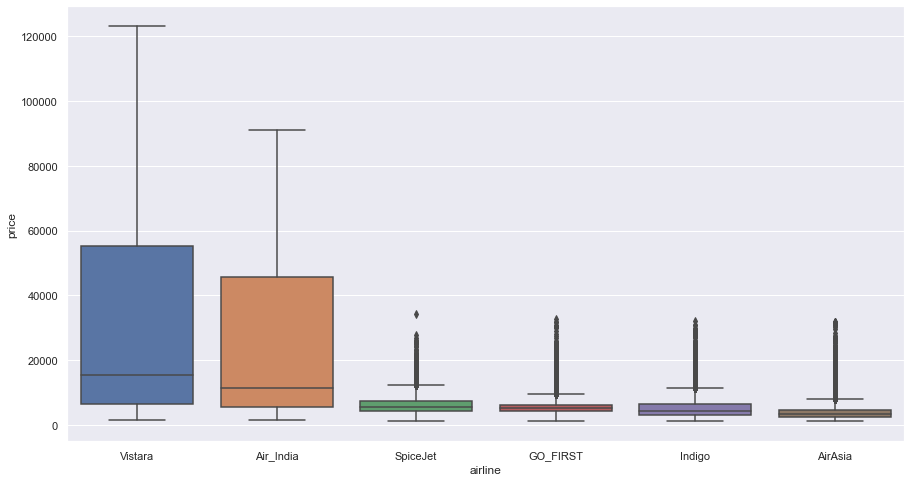

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(x='airline',y='price',data=df.sort_values('price',ascending=False))

In [14]:
categorical['source_city'].value_counts()

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

<Figure size 1080x1080 with 0 Axes>

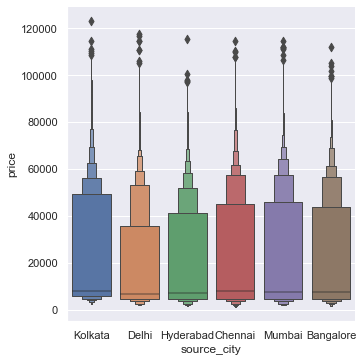

In [15]:
plt.figure(figsize=(15,15))
sns.catplot(x='source_city',y='price',data=df.sort_values('price',ascending=False),kind='boxen')

## Conclusion

The idea is to learn and perform web scraping using Python – this humble attempt of finding the best possible Flight deals is personal milestone and I would like to leverage this to other areas like home search sites, web scrape review sites and then perform sentimental analysis. 


### Future Uses:-
I would like to integrate with Twilio to send text messages instead of emails, improvise the search using multiple inputs, schedule the program using bots or other schedulers for advanced more sophisticated results. I would also like to expand the web scraping to other similar sites with minimal changes to the Python program. I would also like to perform the best possible suggestions on the flight price using RIPPER and Q-Learning algorithms
